## Problem statement: 
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [5]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob

### Importing Skin Cancer Data

In [6]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [8]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [9]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [12]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [14]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [15]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [163]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
visualizing one instance of all the nine classes present in the dataset

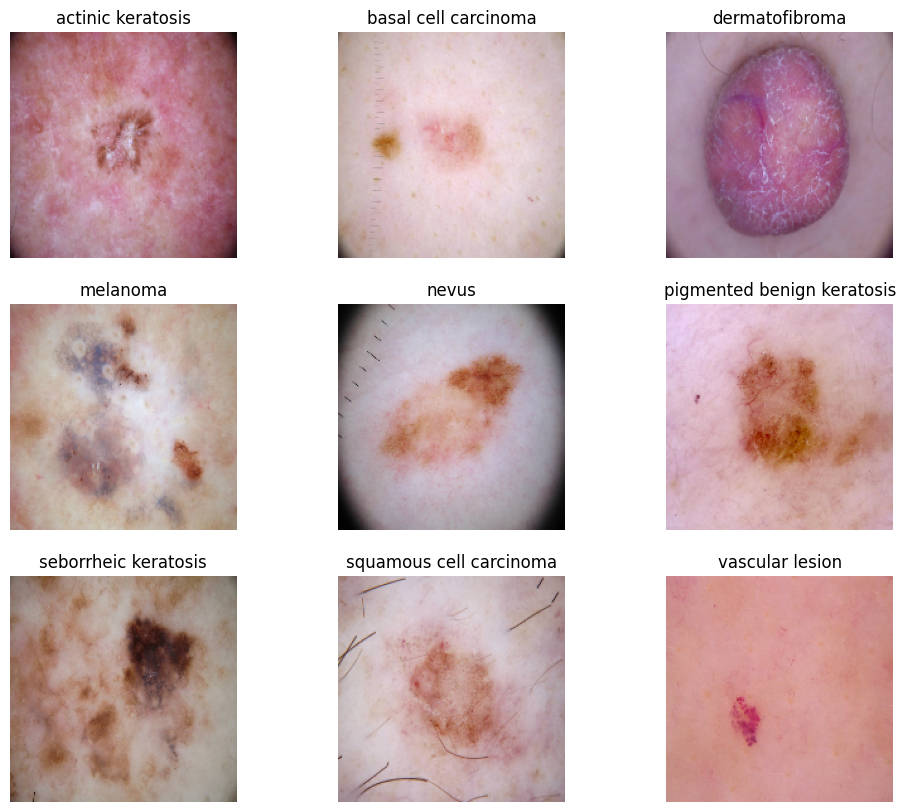

In [26]:
plt.figure(figsize=(12,10))
for i in range(len(class_names)):
  filtered_ds = train_ds.filter(lambda x,l:tf.math.equal(l[0], i))
  for image, label in filtered_ds.take(1):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image[0].numpy().astype('uint8'))
    plt.title(class_names[label.numpy()[0]])
    plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [28]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


<Axes: xlabel='No. of Image', ylabel='Class'>

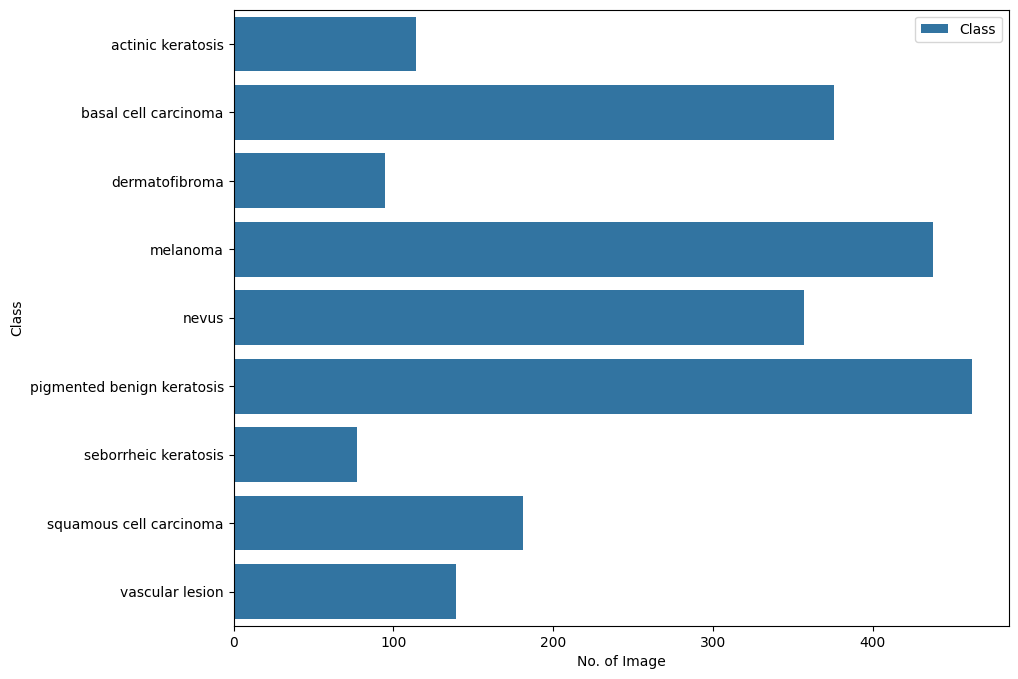

In [30]:
#Visualize the Number of image in each class.

plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

---
---

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [34]:
# Optimize Performance

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
##### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [36]:
#CNN Model Architecture

num_classes = len(class_names)

model = Sequential([
  layers.Input(shape=(img_height, img_width, 3)),
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [38]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [40]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [42]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 207ms/step - accuracy: 0.2179 - loss: 2.0643 - val_accuracy: 0.3221 - val_loss: 1.7804
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.4050 - loss: 1.6440 - val_accuracy: 0.3848 - val_loss: 1.6659
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - accuracy: 0.4871 - loss: 1.4946 - val_accuracy: 0.4877 - val_loss: 1.6217
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - accuracy: 0.4991 - loss: 1.4054 - val_accuracy: 0.5123 - val_loss: 1.4053
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 194ms/step - accuracy: 0.5687 - loss: 1.2165 - val_accuracy: 0.5391 - val_loss: 1.4313
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 200ms/step - accuracy: 0.5795 - loss: 1.2159 - val_accuracy: 0.5369 - val_loss: 1.3712
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step - accuracy: 0.6326 - loss: 1.0199 - val_accuracy: 0.5593 - val_loss: 1.4816
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 197ms/step - accuracy: 0.6359 - loss: 0.9561 - val_accu

In [46]:
# Save model and training history

model.save("melanoma_cnn_model.keras")
pd.DataFrame(history.history).to_csv("training_history.csv")

### Visualizing training results

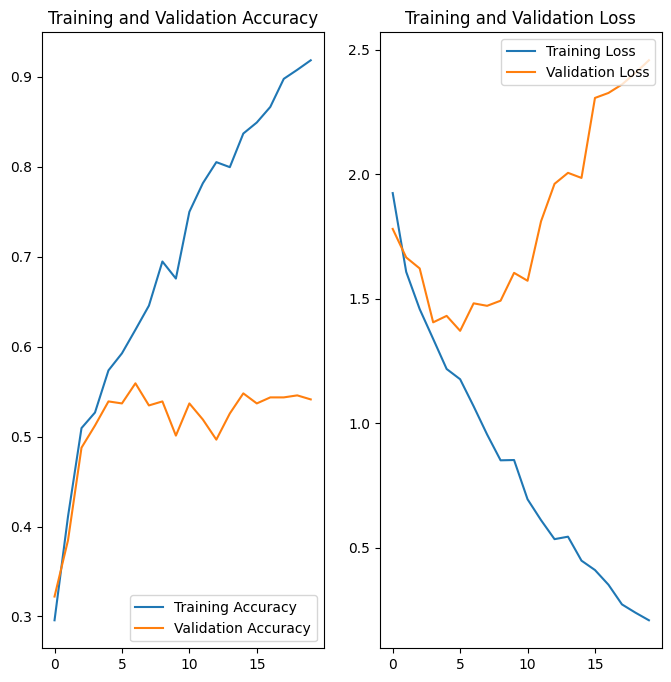

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Interpretation of Training Results
1] Model performs very well on training data but poorly on validation data.<br>
2] The large gap between training accuracy (92.78%) and validation accuracy (54.14%) is a strong sign of overfitting.<br>
3] The high validation loss (2.4575) suggests the model is not learning useful general patterns.<br>
Overall we need to apply techniques like <b>Data Augmentation and Dropout</b> to handle the overfitting issue of the model

---
---

## Data Augmentation

In [54]:
data_augmentation = keras.Sequential(
  [
    layers.Input(shape=(img_height, img_width, 3)), 
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

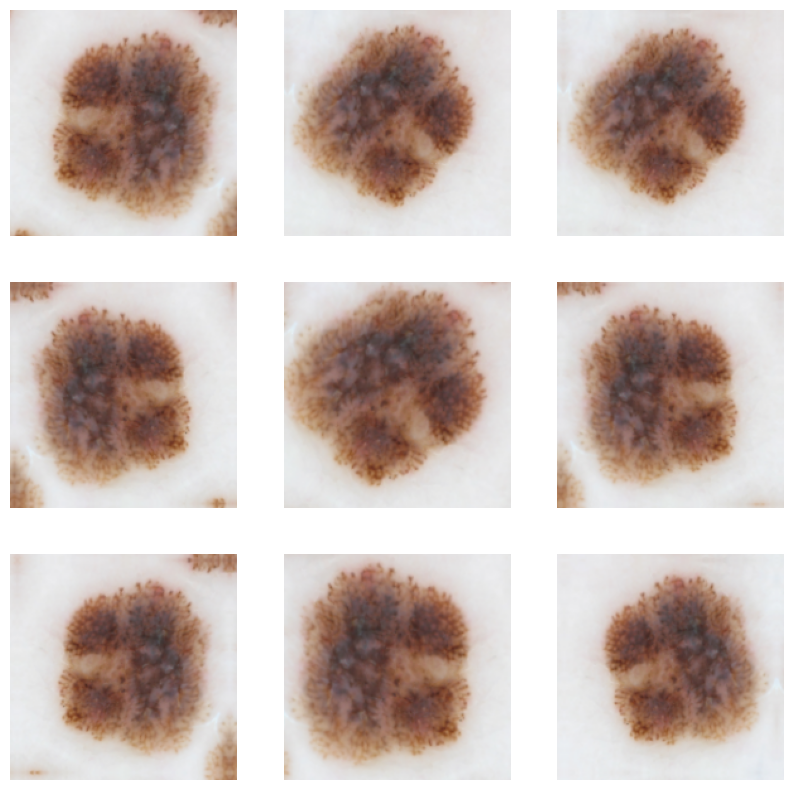

In [56]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the model

In [65]:
# Using Dropout layer as there is an evidence of overfitting in the findings
# Apply augmentation in model

enhanced_model = Sequential([
  layers.Input(shape=(img_height, img_width, 3)),
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

### Compiling the model

In [67]:
enhanced_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Training the augmented model

In [70]:
# train the model for 20 epochs

enhanced_history = enhanced_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 217ms/step - accuracy: 0.2325 - loss: 2.0916 - val_accuracy: 0.3423 - val_loss: 1.7865
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 213ms/step - accuracy: 0.3859 - loss: 1.7331 - val_accuracy: 0.4855 - val_loss: 1.5920
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 216ms/step - accuracy: 0.4556 - loss: 1.5781 - val_accuracy: 0.4855 - val_loss: 1.4829
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 211ms/step - accuracy: 0.4582 - loss: 1.5486 - val_accuracy: 0.5257 - val_loss: 1.4282
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 229ms/step - accuracy: 0.4969 - loss: 1.4032 - val_accuracy: 0.5280 - val_loss: 1.3964
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 230ms/step - accuracy: 0.5266 - loss: 1.3730 - val_accuracy: 0.5235 - val_loss: 1.3619
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 227ms/step - accuracy: 0.5439 - loss: 1.3157 - val_accuracy: 0.5302 - val_loss: 1.3187
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 233ms/step - accuracy: 0.5438 - loss: 1.2600 - val_accu

In [76]:
enhanced_model.save("melanoma_cnn_augmented_model.keras")
pd.DataFrame(enhanced_history.history).to_csv("enhanced_training_history.csv")

### Visualizing the results

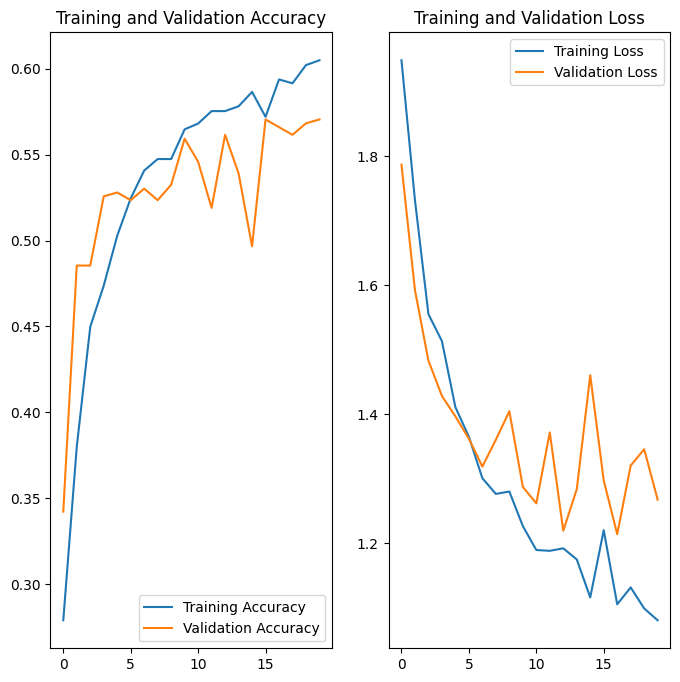

In [159]:
acc = enhanced_history.history['accuracy']
val_acc = enhanced_history.history['val_accuracy']

loss = enhanced_history.history['loss']
val_loss = enhanced_history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Interpretation of Training Results
1] The model is not learning complex patterns well enough. <br>
2] The training accuracy (59.89%) is only slightly higher than validation accuracy (57.05%), meaning the model is not memorizing the training data (which is good).<br>
3] However, both accuracies are low, which suggests the model's capacity might be too limited.<br>

This result suggests **underfitting** rather than overfitting

---
---

#### Distribution of classes in the training dataset.
##### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [88]:
# Convert data directory to Path object
data_dir = Path(data_dir_train)

# Generate paths and labels in a single loop
data = [(str(img_path), img_path.parent.name) for img_path in data_dir.rglob("*.jpg")]

df = pd.DataFrame(data, columns=["Path", "Label"])
df


,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
1,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
2,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
3,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
4,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
...,...,...
2234,Skin cancer ISIC The International Skin Imagin...,vascular lesion
2235,Skin cancer ISIC The International Skin Imagin...,vascular lesion
2236,Skin cancer ISIC The International Skin Imagin...,vascular lesion
2237,Skin cancer ISIC The International Skin Imagin...,vascular lesion


Class=0, n=114 (5.092%)
Class=1, n=376 (16.793%)
Class=2, n=95 (4.243%)
Class=3, n=438 (19.562%)
Class=4, n=357 (15.945%)
Class=5, n=462 (20.634%)
Class=6, n=77 (3.439%)
Class=7, n=181 (8.084%)
Class=8, n=139 (6.208%)


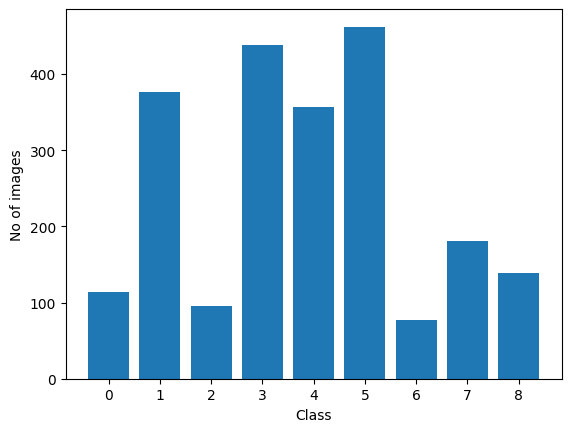

In [90]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter

X, y = df['Path'], df['Label']
y = LabelEncoder().fit_transform(y)
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

plt.bar(counter.keys(), counter.values())
plt.xticks([i for i in range(9)])
plt.xlabel("Class")
plt.ylabel("No of images")
plt.show()

#### - Which class has the least number of samples?
<b>Ans]</b> From the above bar chart we can see that the class with label 6 has the least number of samples
#### - Which classes dominate the data in terms proportionate number of samples?
<b>Ans]</b> We can observe that of all the class, class with label 5 has the most number of samples


---
---

#### Rectify the class imbalance
##### **Context:** Using a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [51]:
!pip install Augmentor


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [92]:
path_to_training_dataset = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")

import Augmentor

for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset) + "/" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21C4E1C0440>: 100%|██████████| 500/500 [00:03<00:00, 137.37 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21C4BAF7C20>: 100%|██████████| 500/500 [00:03<00:00, 134.24 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x21C4E2680E0>: 100%|██████████| 500/500 [00:02<00:00, 170.04 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x21C4E1A2240>: 100%|██████████| 500/500 [00:15<00:00, 32.10 Samples/s]                  


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1504x1129 at 0x21C5042F950>: 100%|██████████| 500/500 [00:11<00:00, 43.35 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x21C4E28F500>: 100%|██████████| 500/500 [00:02<00:00, 169.89 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x21C4BC00050>: 100%|██████████| 500/500 [00:06<00:00, 79.68 Samples/s]                   


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21C3236F410>: 100%|██████████| 500/500 [00:02<00:00, 175.52 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21C4BABB200>: 100%|██████████| 500/500 [00:03<00:00, 130.60 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [105]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [107]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_085e0196-ae00-4085-810e-944fb6e50c6f.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_0cdff366-9036-444e-b1c6-cdce5099d126.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_4f51e07a-5fde-4c73-a862-c715ab69fffc.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_5281e304-bd80-493c-bf0f-25c01aa264c4.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_545616c7-d0f2-4202-8a89-b69ecc6d1b9f.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train

In [109]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [113]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [115]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns = ['Path','Label'])
new_df = pd.concat([df, df2], ignore_index=True)

In [117]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

##### So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Train the model on the data created using Augmentor

In [123]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [126]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [129]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create the model (includes normalization)

In [135]:
augmentor_model = Sequential([
    layers.Input(shape=(img_height, img_width, 3)), # Input Layer
   
    # Data Augmentation 
    data_augmentation,

    # Normalization
    layers.Rescaling(1./255),

    # Convolutional Layers with Batch Normalization
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Regularization
    layers.Dropout(0.2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(), # Normalizing dense layer activations
    layers.Dense(num_classes, activation='softmax') # Output Layer
])

#### Compile the model

In [142]:
augmentor_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

#### Train the model

In [144]:
epochs = 30

augmentor_history = augmentor_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 118s 652ms/step - accuracy: 0.3872 - loss: 1.8940 - val_accuracy: 0.1158 - val_loss: 3.2254
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 102s 603ms/step - accuracy: 0.5552 - loss: 1.2148 - val_accuracy: 0.3177 - val_loss: 2.1148
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 103s 607ms/step - accuracy: 0.5981 - loss: 1.0937 - val_accuracy: 0.3304 - val_loss: 2.2183
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 102s 603ms/step - accuracy: 0.6387 - loss: 0.9975 - val_accuracy: 0.6095 - val_loss: 1.0681
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 102s 605ms/step - accuracy: 0.6724 - loss: 0.9149 - val_accuracy: 0.5501 - val_loss: 1.1983
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 103s 608ms/step - accuracy: 0.6964 - loss: 0.8416 - val_accuracy: 0.5204 - val_loss: 1.3433
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 103s 608ms/step - accuracy: 0.7202 - loss: 0.7845 - val_accuracy: 0.6414 - val_loss: 0.9560
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 103s 607ms/step - accuracy: 0.7283 -

#### Visualize the model results

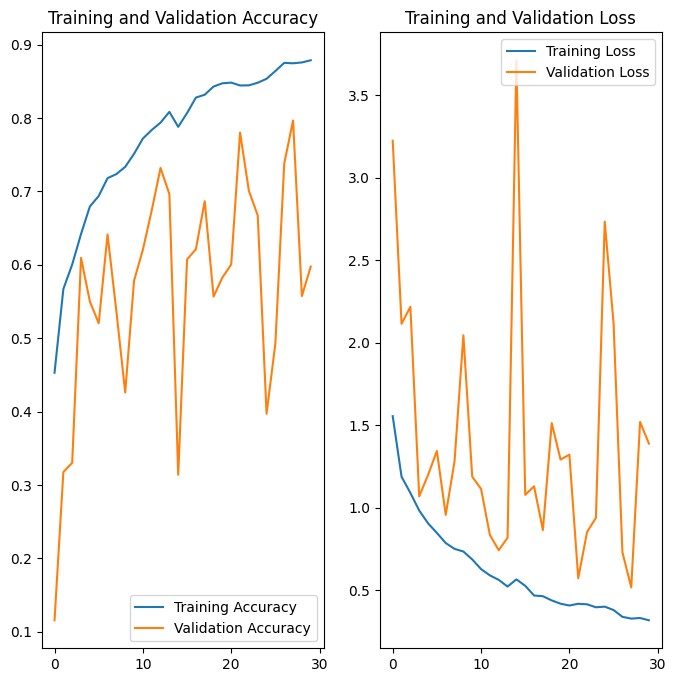

In [166]:
acc = augmentor_history.history['accuracy']
val_acc = augmentor_history.history['val_accuracy']

loss = augmentor_history.history['loss']
val_loss = augmentor_history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Interpretation of Final Results

#### Did we Fix Underfitting or Overfitting?
1] **Overfitting** is still present! <br>
2] The training accuracy is very high (88.51%), but validation accuracy is much lower (59.76%).<br>
3] A large gap between training and validation accuracy suggests the model is **memorizing training data** instead of generalizing well.<br>
4] **Validation loss is still high**, meaning the model struggles with unseen data.<br>

#### Did Class Rebalancing Help?
1] Possibly, but not enough. <br>
2] However, the low validation accuracy suggests that the model might still struggle with imbalanced data or have other issues like dataset size, augmentation, or architecture limitations.